In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
import winsound
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, isa_vit_metric, Tracker

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
vit_tk = Tracker()
rpn_tk = Tracker()

### Monitoring and CUDA Setup


In [3]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_19_2024_224509'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
vit_tk.date = rn
vit_tk.logfile = f'rpn_vit_{dte}.log'
vit_tk.device = device

rpn_tk.date = rn
rpn_tk.logfile = f'rpn_vit_{dte}.log'
rpn_tk.device = device

### Config for RPN and ViT Fitter


In [6]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        global_context=True,
        nh=4,
        pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.SmoothL1Loss(),
    'lr': 0.0001
}

C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=32,
        dim_ff=1600,
        global_context=True,
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.BCEWithLogitsLoss(),
    'lr': 0.0001
}

In [8]:
vit_tk.model = 'ViT'
vit_tk.model_hyperparams = vit_config['model'].config
vit_tk.optimizer = f"{vit_config['optimizer']}"
vit_tk.epochs = vit_config['epochs']
vit_tk.loss = f"{vit_config['loss']}"
vit_tk.lr = vit_config['lr']

rpn_tk.model = 'RPN'
rpn_tk.model_hyperparams = rpn_config['model'].config
rpn_tk.uses_resnet = rpn_config['model'].config['pretrained']
rpn_tk.optimizer = f"{rpn_config['optimizer']}"
rpn_tk.epochs = rpn_config['epochs']
rpn_tk.loss = f"{rpn_config['loss']}"
rpn_tk.lr = rpn_config['lr']

### Dataset Loading


In [9]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [10]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
vit_tk.only_cmb_slices = True
rpn_tk.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,8,1,1,1,928.405273,35
1,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,9,1,1,1,928.405273,35
2,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,11,1,1,1,928.405273,35
3,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,12,1,1,1,928.405273,35
4,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,241.000000,36
360,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,26,1,1,3,241.000000,36
361,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,24,1,1,3,448.000000,39
362,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [11]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 rpn_tracker=rpn_tk,
                 vit_tracker=vit_tk
                ):
    if cohort == 1:
        rpn_tracker.cohort1 = True
        vit_tracker.cohort1 = True
    if cohort == 2:
        rpn_tracker.cohort2 = True
        vit_tracker.cohort2 = True
    if cohort == 3:
        rpn_tracker.cohort3 = True
        vit_tracker.cohort3 = True
    
    rpn_tracker.test_size = test_size
    vit_tracker.target_shape = target_shape
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### RPN Fitter


In [12]:
from project import Fitter

In [13]:
class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                # x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    # x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric
                

### ViT Fitter


In [14]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader, stage1):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader, stage1)
            val_loss, val_metric = self.validation(val_loader, stage1)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader, stage1):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # slices = slices.squeeze(1).float().to(self.device)
                slices = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                masks = masks.float().to(self.device)

                with torch.inference_mode():
                    x, t = stage1(slices, masks, target)
                
                # self.log(f'{x.requires_grad}, {t.requires_grad}')
                # self.log(f'{x.shape}, {t.shape}')

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                
                # print('Prediction:', (y.sigmoid() >= 0.5).int().unique())
                # print('Truth:', (t[target] >= 0).int().unique())

                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {dice_score, precision_score, recall_score, f1_score, fpr}')

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader, stage1):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # slices = slices.squeeze(1).float().to(self.device)
                    slices = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    x, t = stage1(slices, masks, target)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

### Train-Test Split


In [15]:
rpn_t1, rpn_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=True
)

rpn_t3, rpn_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=True
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [16]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [17]:
from torch.utils.data import ConcatDataset

rpn_train_set = ConcatDataset([rpn_t1, rpn_t3])
rpn_test_set = ConcatDataset([rpn_v1, rpn_v3])

print(f'RPN Train Set Size: {rpn_train_set}')
print(f'RPN Test Set Size: {rpn_test_set}')

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

RPN Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000002BA5C9C6020>
RPN Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000002BA5C9C7A30>
ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000002BA5C9C7A90>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x000002BA5C9C6E00>


In [18]:
batchs = 20

rpn_test_dataloader = DataLoader(
    rpn_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [19]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [21]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

image_size = 300
patch_size = 32

In [22]:
rpn_test_iou = []
rpn_test_precision = []
rpn_test_recall = []
rpn_test_f1 = []

vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

In [23]:
rpn_fold_metrics = []
vit_fold_metrics = []


fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(rpn_train_set)):
    print(f'Fold {i + 1}/{5}')
    logger.info(f'################################### Fold {i+1}/5 ###################################')
    
    # RPN
    rpn_config['model'] = RPN(**rpn_tk.model_hyperparams).to(device)
    
    rpn_fitter = RPNFitter(rpn_config, logger=logger)
    
    rpn_train_subset = Subset(rpn_train_set, train_index)
    rpn_val_subset = Subset(rpn_train_set, val_index)

    rpn_tk.batch_size = 2
    
    rpn_train_subset_dl = DataLoader(
        rpn_train_subset,
        shuffle=True,
        batch_size=rpn_tk.batch_size,
        collate_fn=collatev2
    )
    
    rpn_val_subset_dl = DataLoader(
        rpn_val_subset,
        shuffle=True,
        batch_size=rpn_tk.batch_size,
        collate_fn=collatev2
    )
    
    rpn_thist, rpn_vhist, rpn_tmhist, rpn_vmhist = rpn_fitter.fit(rpn_train_subset_dl, rpn_val_subset_dl)
    
    rpn_fold_metrics.append({
        'fold': i + 1,
        'training_history': rpn_thist,
        'validation_history': rpn_vhist,
        'training_metrics': rpn_tmhist,
        'validation_metrics': rpn_vmhist
    })
    
    rpn_h, rpn_mh = rpn_fitter.validation(rpn_test_dataloader)
    rpn_valmets = pd.DataFrame(rpn_mh)
    rpn_mets = rpn_valmets.mean()
    
    rpn_test_iou.append(rpn_mets.iou_score)
    rpn_test_precision.append(rpn_mets.precision_score)
    rpn_test_recall.append(rpn_mets.recall_score)
    rpn_test_f1.append(rpn_mets.f1_score)
    
    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)
    torch.save(rpn_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/rpn_fold{i+1}.pt')
    
    # FEEDER
    
    resize = get_transform(
        height=patch_size,
        width=patch_size,
        p=1.0,
        rpn_mode=False
    )

    feeder = Feeder(resize)
    stone = GCRPN(
        rpn=rpn_fitter.model,
        feeder=feeder,
        image_size=image_size,
        patch_size=patch_size
    ).to(device)
    
    # ViT
    
    vit_config['model'] = ISAVIT(**vit_tk.model_hyperparams).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)

    vit_tk.batch_size = 2
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl, stone)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader, stone)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)
    
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

INFO:kess:################################### Fold 1/5 ###################################


Fold 1/5


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================
C:\Program Files\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Program Files\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cud

Fold 2/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.07647860795259476

INFO:kess:Batch:	2/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.015852557495236397

INFO:kess:Batch:	3/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.015757624059915543

INFO:kess:Batch:	4/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.02939695678651333

INFO:kess:Batch:	5/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.008407896384596825

INFO:kess:Batch:	6/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.02341880090534687

INFO:kess:Batch:	7/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.020408958196640015

INFO:kess:Batch:	8/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.024032842367887497

INFO:kess:Batch:	9/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.018767472356557846

INFO:kess:Batch:	10/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.0309088584035

Fold 3/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.04427747428417206

INFO:kess:Batch:	2/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.014737882651388645

INFO:kess:Batch:	3/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.009707740508019924

INFO:kess:Batch:	4/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.0069017428904771805

INFO:kess:Batch:	5/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.01655811071395874

INFO:kess:Batch:	6/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.016773737967014313

INFO:kess:Batch:	7/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.015711011365056038

INFO:kess:Batch:	8/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.01958421990275383

INFO:kess:Batch:	9/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.012049946933984756

INFO:kess:Batch:	10/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.026375854387

Fold 4/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.025854960083961487

INFO:kess:Batch:	2/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.007797725033015013

INFO:kess:Batch:	3/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.019884664565324783

INFO:kess:Batch:	4/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.005676602944731712

INFO:kess:Batch:	5/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.010462219826877117

INFO:kess:Batch:	6/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.004984558094292879

INFO:kess:Batch:	7/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.024168895557522774

INFO:kess:Batch:	8/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.016912104561924934

INFO:kess:Batch:	9/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.012143325060606003

INFO:kess:Batch:	10/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.0192945636

Fold 5/5


INFO:kess:EPOCH 0 ==============================
INFO:kess:Batch:	1/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.022272668778896332

INFO:kess:Batch:	2/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.027856837958097458

INFO:kess:Batch:	3/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.00799744576215744

INFO:kess:Batch:	4/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.008815523236989975

INFO:kess:Batch:	5/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.027255579829216003

INFO:kess:Batch:	6/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.026920389384031296

INFO:kess:Batch:	7/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.01976804807782173

INFO:kess:Batch:	8/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.02210734412074089

INFO:kess:Batch:	9/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.01871979795396328

INFO:kess:Batch:	10/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.02171493507921

In [24]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


`rpn_fold_metrics[i]`

- represents each fold

`rpn_fold_metrics[1].keys()`

- 'fold', 'training_history', 'validation_history', 'training_metrics', 'validation_metrics'

`rpn_fold_metrics[1]['training_metrics'][i]`

- represents each epoch

`rpn_fold_metrics[1]['training_metrics'][1].keys()`

- 'iou_score', 'precision_score', 'recall_score', 'f1_score'


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def plot_metric_history(fold_metrics, metric, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(len(rpn_fold_metrics)):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        sns.lineplot(x=range(1, len(train)+1), y=train, label=f'Training {metric}', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label=f'Validation {metric}', ax=ax)
    
    
        ax.set_title(f'{title}Training and Validation {metric}: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        
    plt.tight_layout()  
    plt.show()

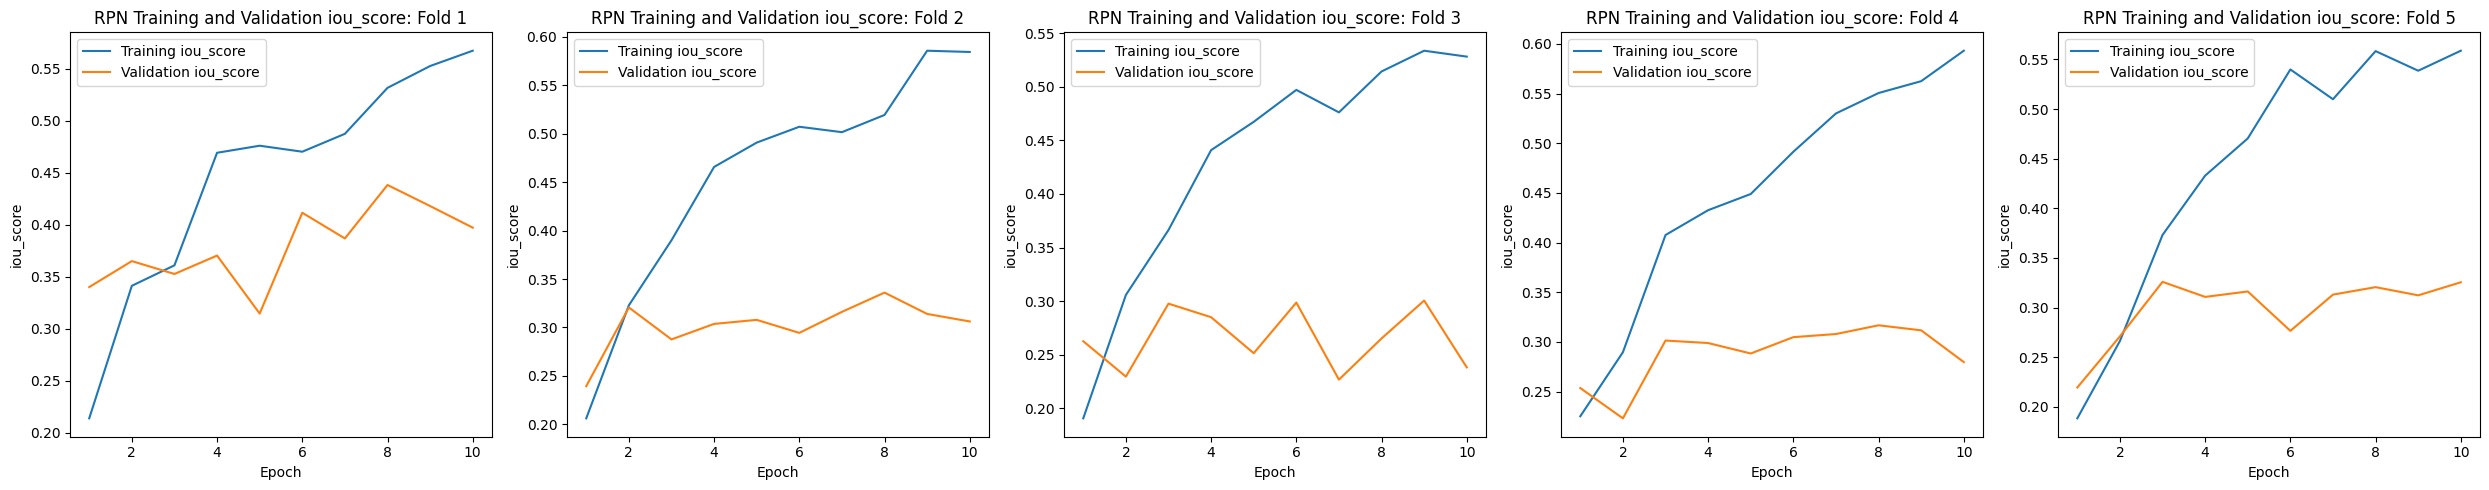

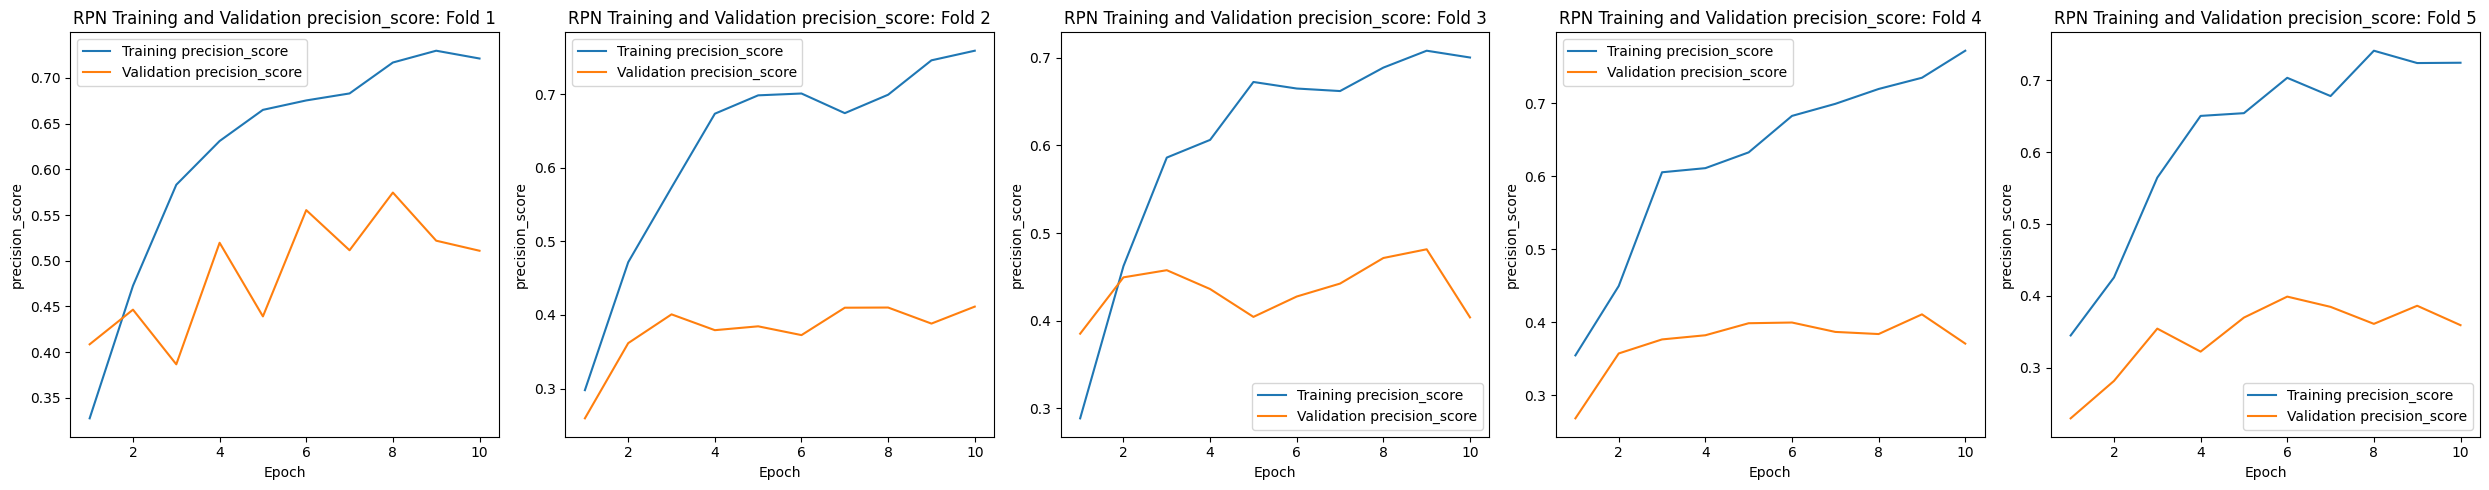

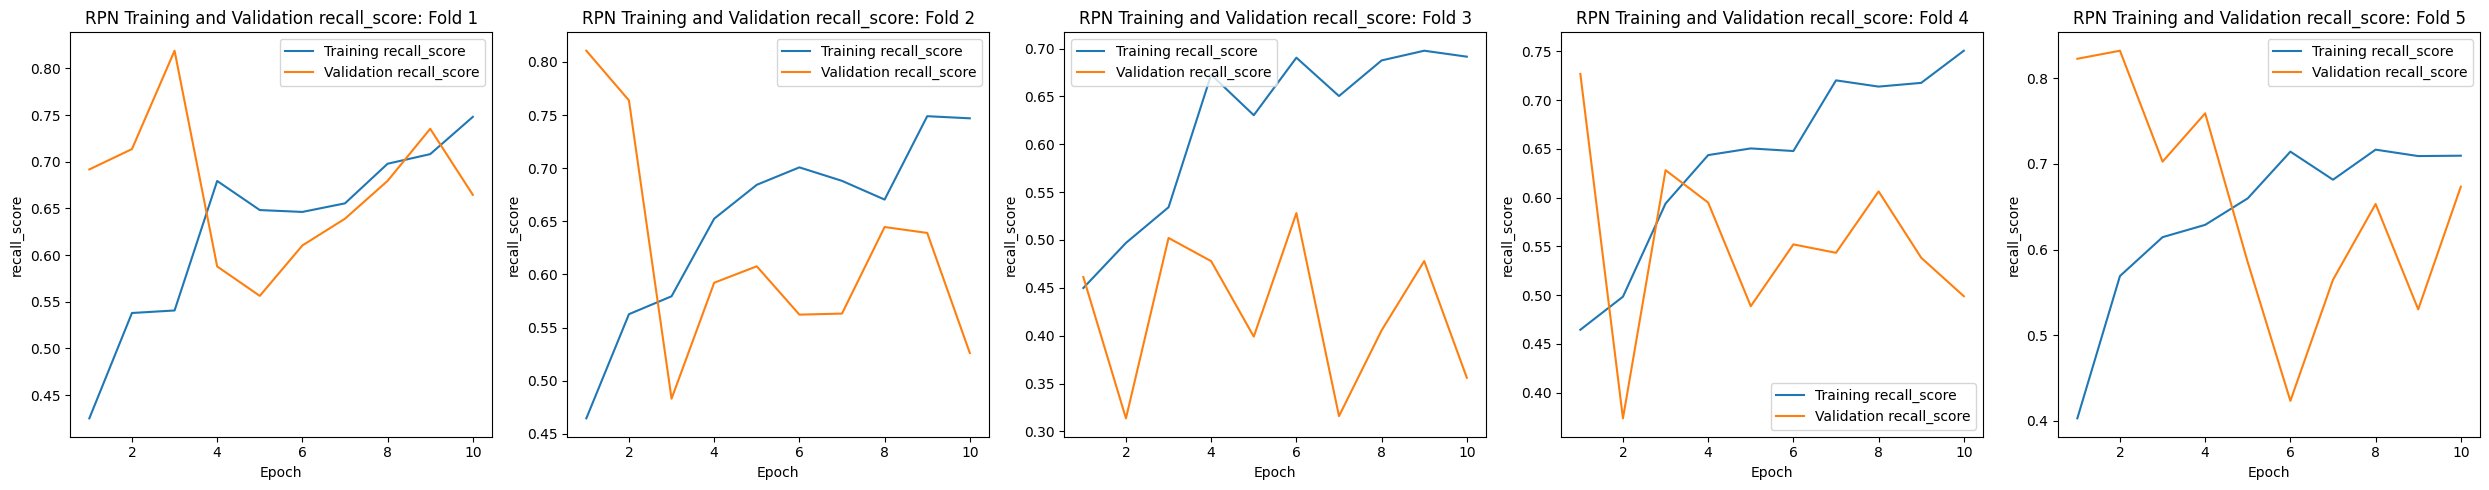

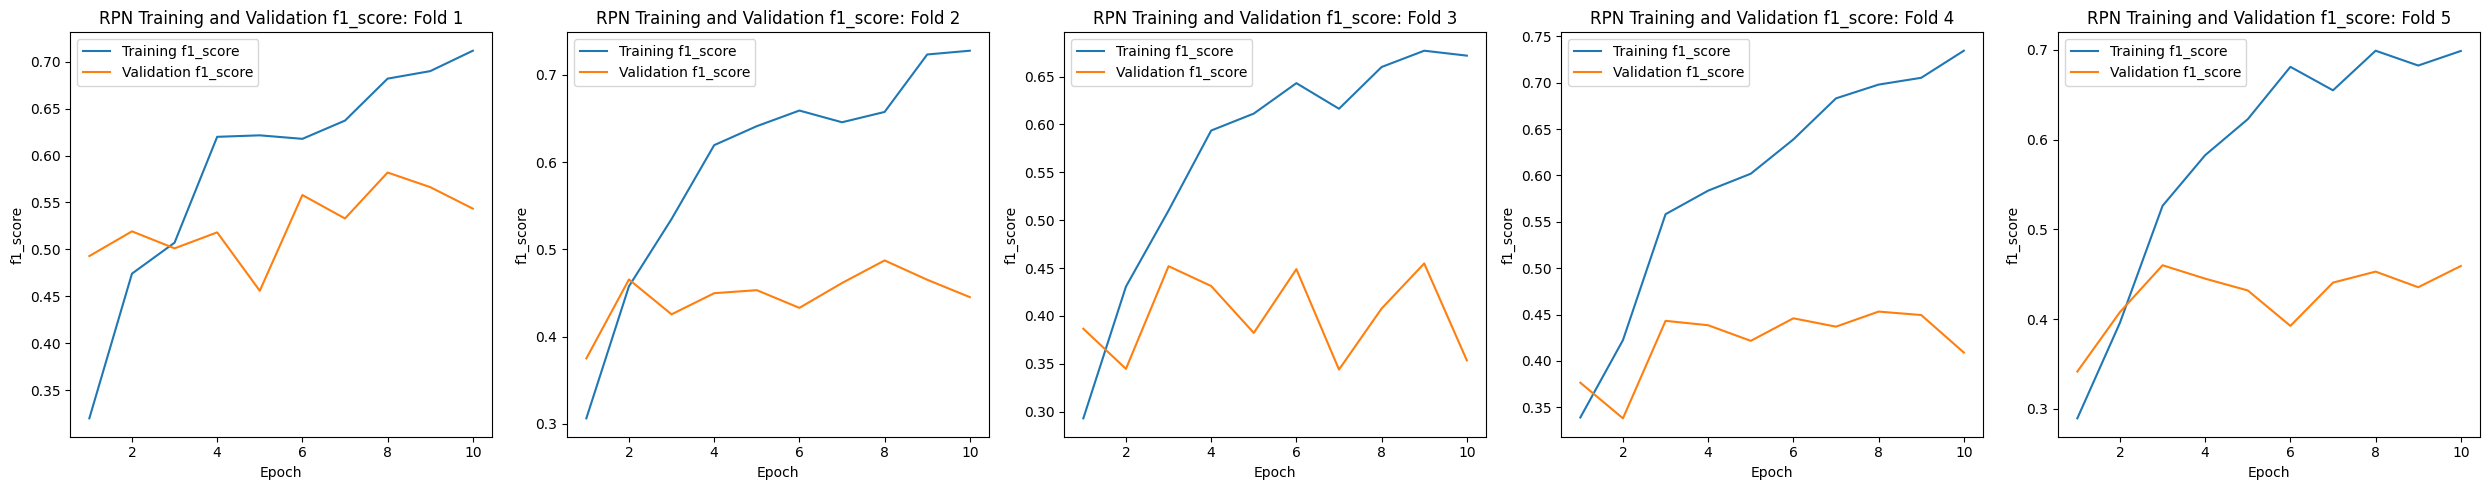

In [27]:
rpn_metrics = ['iou_score', 'precision_score', 'recall_score', 'f1_score']

for metric in rpn_metrics:
    plot_metric_history(rpn_fold_metrics, metric, 'RPN ')

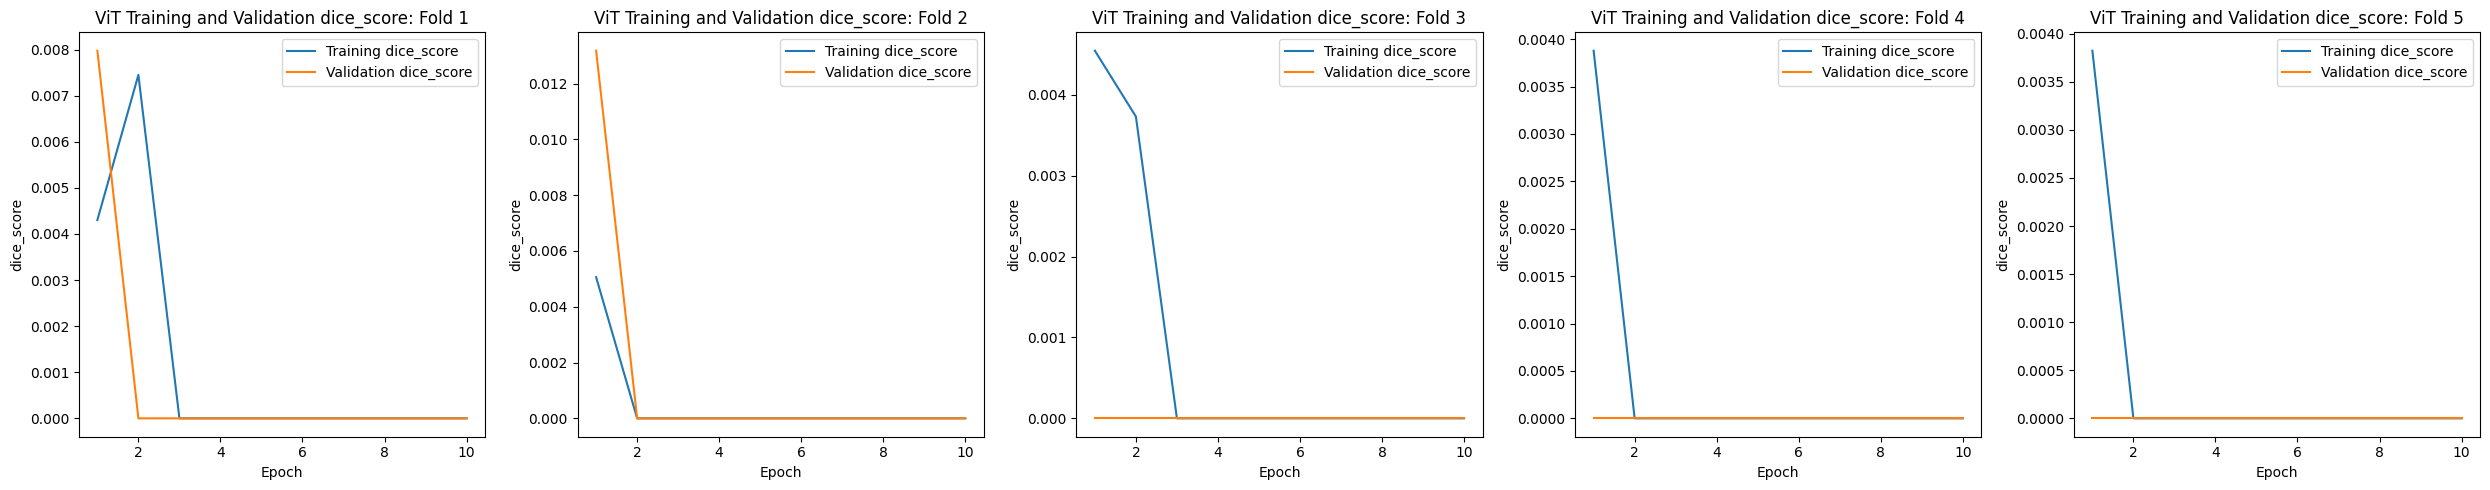

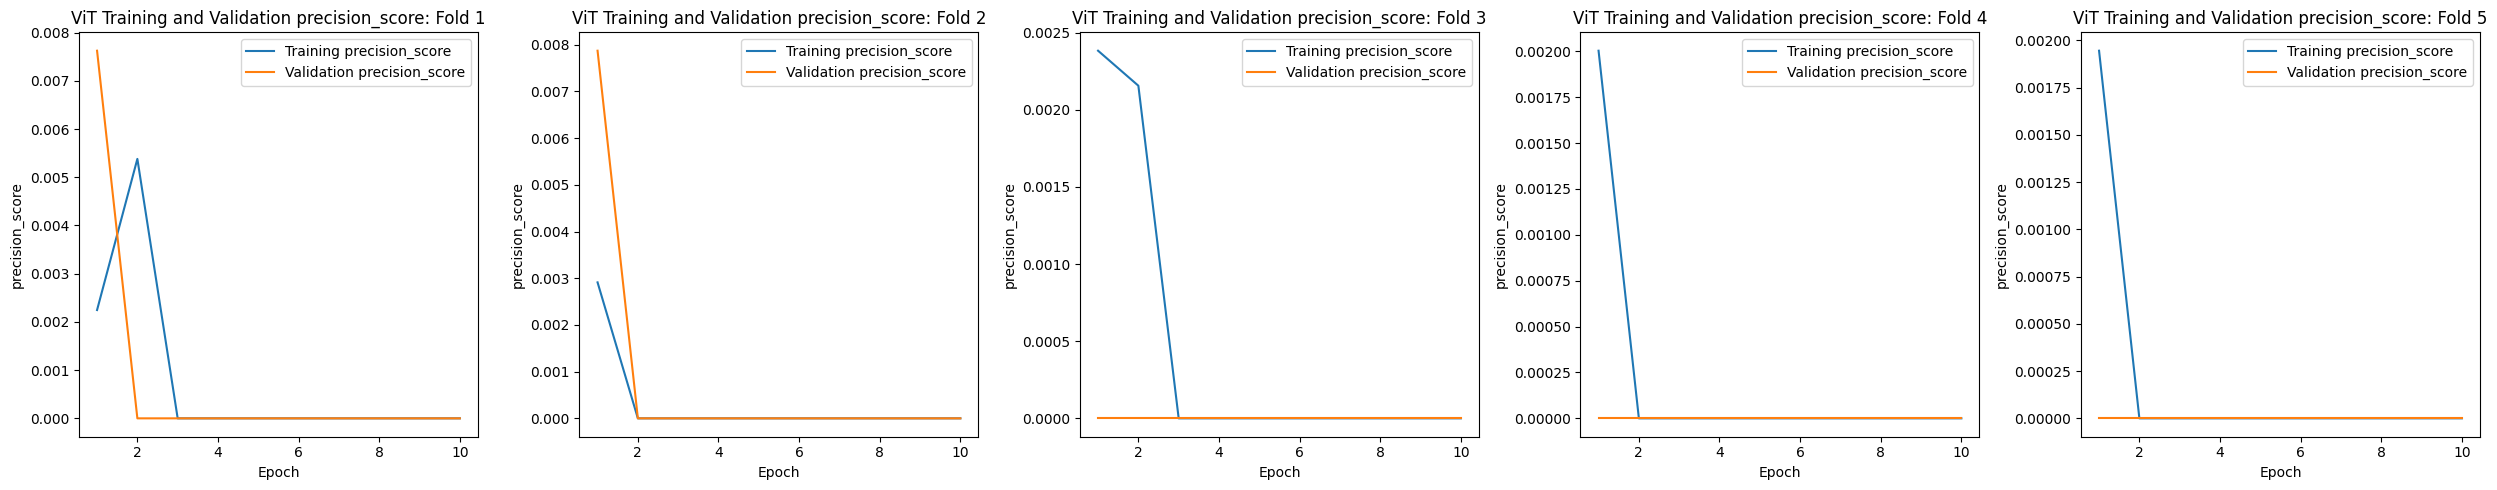

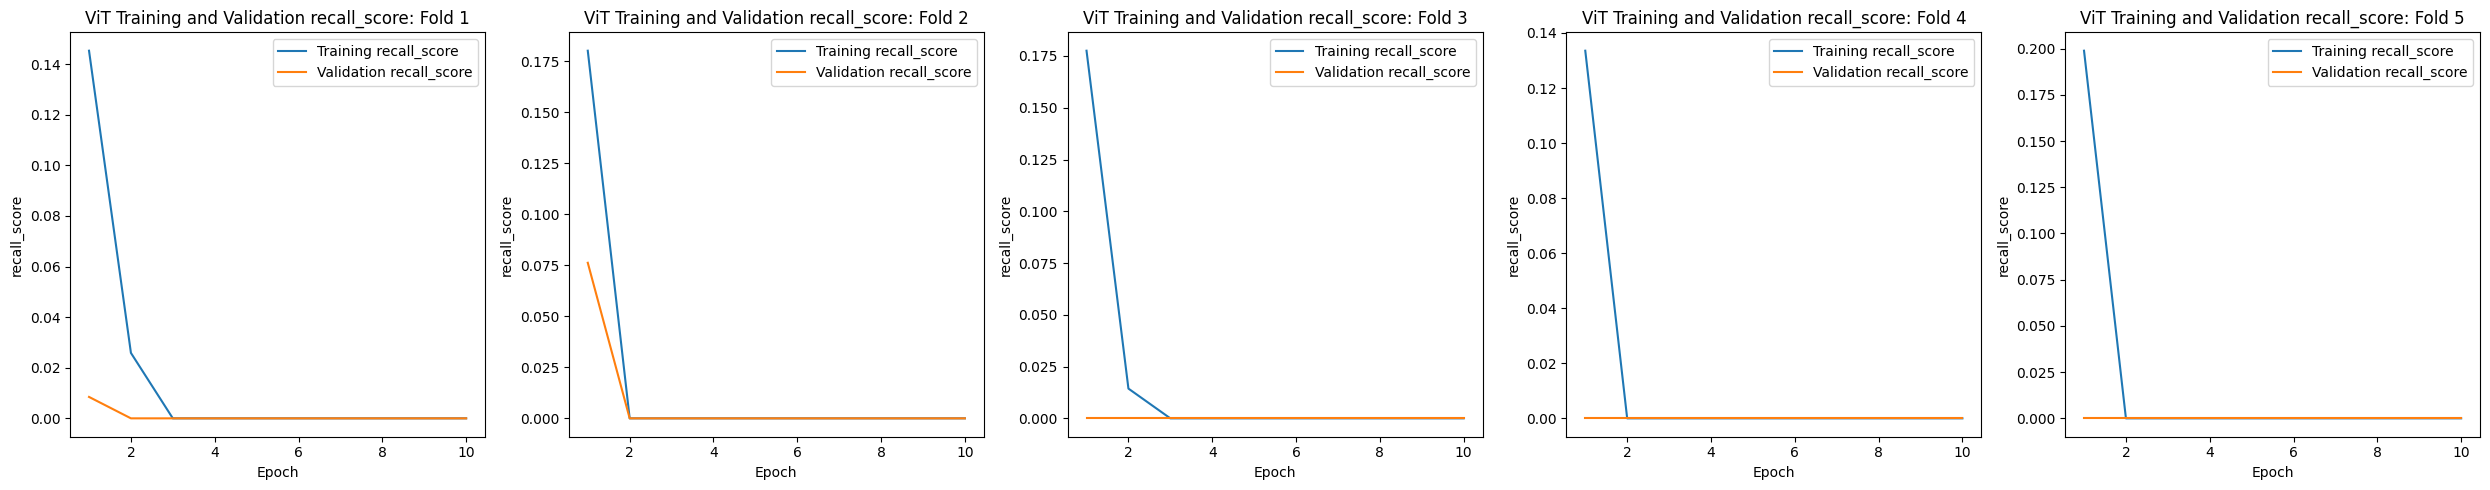

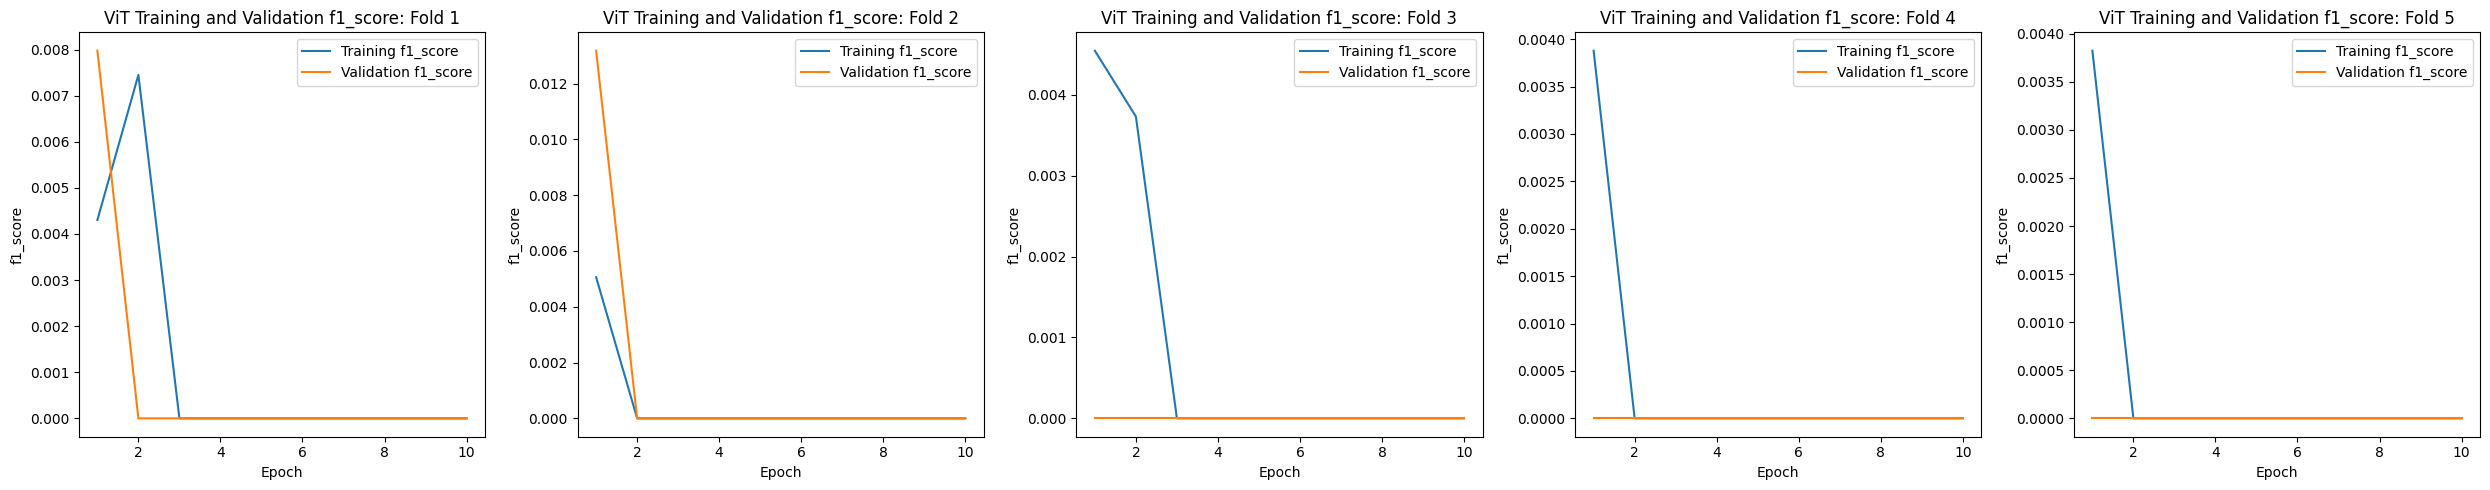

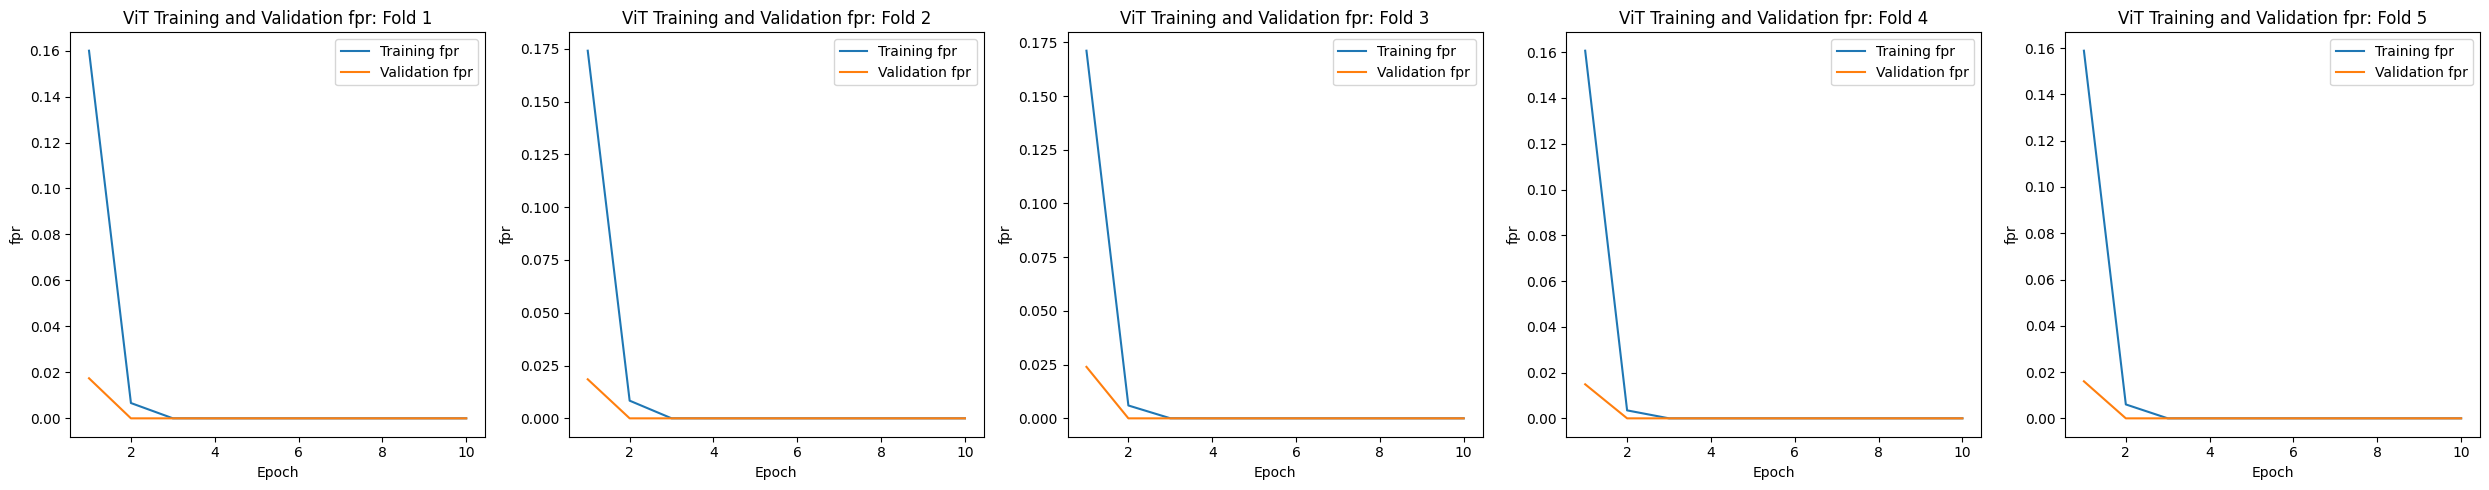

In [28]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [29]:
def plot_loss_history(fold_metrics, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(5):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
        
        sns.lineplot(x=range(1, len(train)+1), y=train, label='Training history', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label='Validation history', ax=ax)
        
        ax.set_title(f'{title}Training and Validation History: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
    
    plt.tight_layout()  
    plt.show()

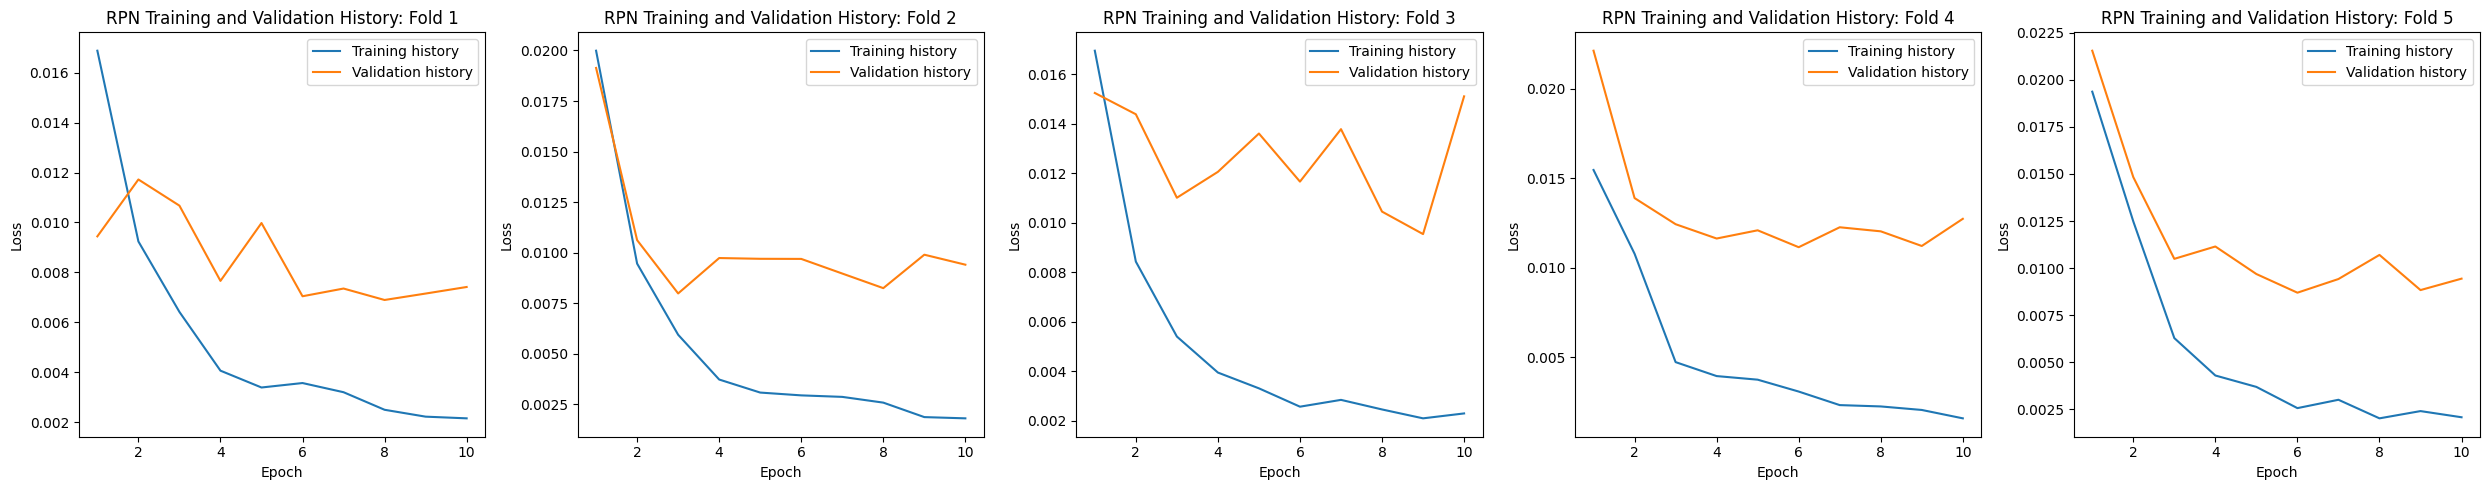

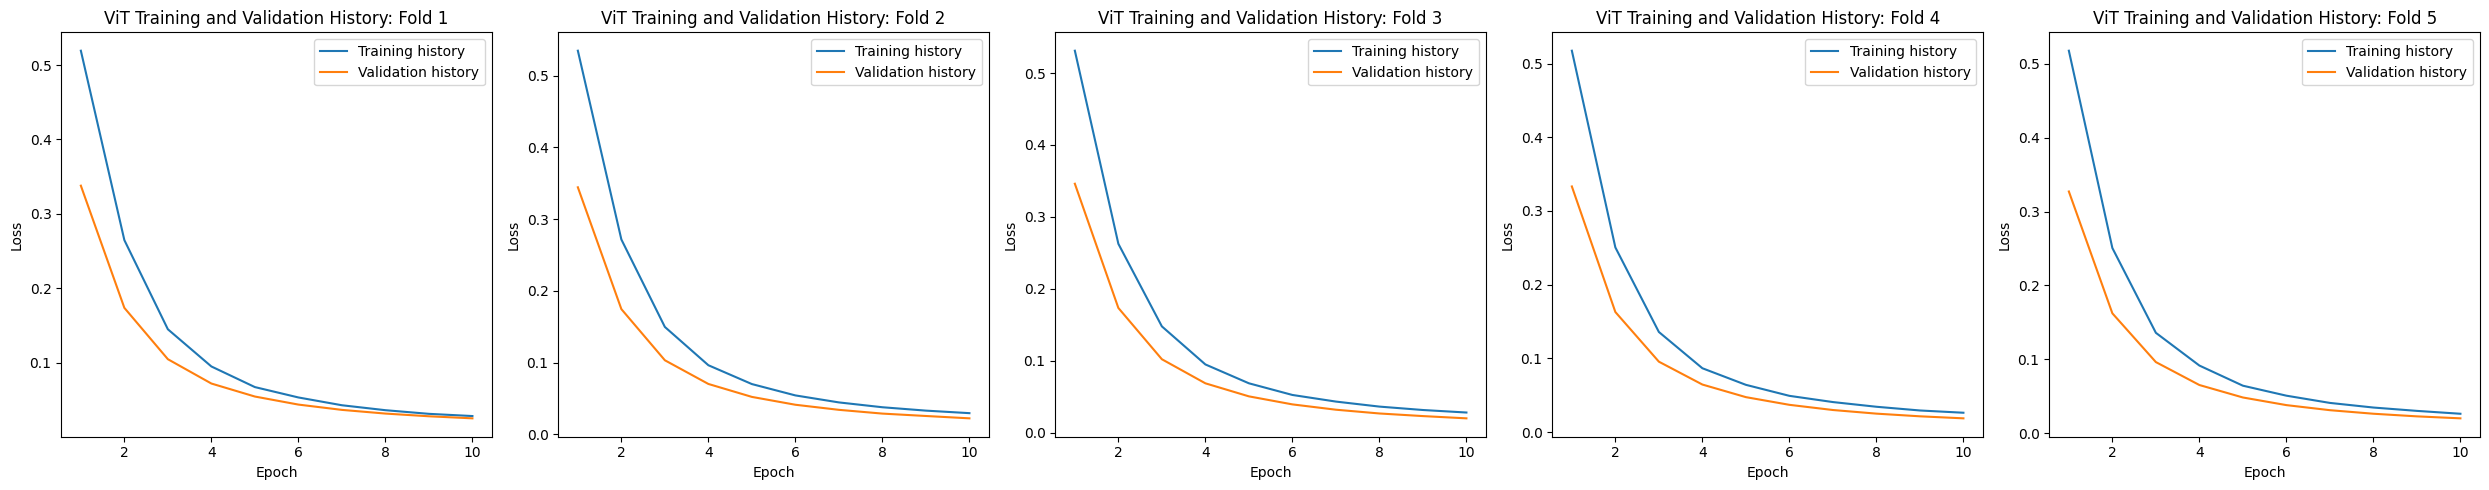

In [30]:
plot_loss_history(rpn_fold_metrics, 'RPN ')
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### RPN


In [31]:
df_rpn_metrics = pd.DataFrame(columns=['fold', 'iou', 'precision', 'recall', 'f1'])
df_rpn_metrics

,fold,iou,precision,recall,f1


In [32]:
df_rpn_metrics['fold'] = [1, 2, 3, 4, 5]
df_rpn_metrics['iou'] = rpn_test_iou
df_rpn_metrics['precision'] = rpn_test_precision
df_rpn_metrics['recall'] = rpn_test_recall
df_rpn_metrics['f1'] = rpn_test_f1

In [33]:
rpn_tk.iou = df_rpn_metrics.iou.mean()
rpn_tk.precision = df_rpn_metrics.precision.mean()
rpn_tk.recall = df_rpn_metrics.recall.mean()
rpn_tk.f1 = df_rpn_metrics.f1.mean()

In [34]:
df_rpn_metrics

,fold,iou,precision,recall,f1
0,1,0.333569,0.434368,0.605788,0.477477
1,2,0.310685,0.417214,0.553520,0.448182
2,3,0.241598,0.352285,0.456293,0.365966
3,4,0.320167,0.403311,0.601431,0.456864
4,5,0.313314,0.379115,0.672164,0.459261


In [35]:
rpn_iou_score = np.array(rpn_test_iou).mean()
rpn_precision_score = np.array(rpn_test_precision).mean()
rpn_recall_score = np.array(rpn_test_recall).mean()
rpn_f1_score = np.array(rpn_test_f1).mean()

print('RPN Test Set Performance Metrics')
print(f'Average IOU: {rpn_iou_score} ')
print(f'Average Precision: {rpn_precision_score} ')
print(f'Average Recall: {rpn_recall_score} ')
print(f'Average F1 Score: {rpn_f1_score} ')

RPN Test Set Performance Metrics
Average IOU: 0.3038666966126154 
Average Precision: 0.3972585868678594 
Average Recall: 0.5778392184721797 
Average F1 Score: 0.44154975849546885 


In [36]:
df_rpn_metrics.to_csv(f'{fold_dir}/rpn_metrics.csv')

#### ViT


In [37]:
df_vit_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_vit_metrics

,fold,dice,precision,recall,f1,fpr


In [38]:
df_vit_metrics['fold'] = [1, 2, 3, 4, 5]
df_vit_metrics['dice'] = vit_test_dice
df_vit_metrics['precision'] = vit_test_precision
df_vit_metrics['recall'] = vit_test_recall
df_vit_metrics['f1'] = vit_test_f1
df_vit_metrics['fpr'] = vit_test_fpr

In [39]:
vit_tk.dice = df_vit_metrics.dice
vit_tk.precision = df_vit_metrics.precision
vit_tk.recall = df_vit_metrics.recall
vit_tk.f1 = df_vit_metrics.f1
vit_tk.fpr = df_vit_metrics.fpr

In [40]:
df_vit_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0


In [41]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.0 
Average Precision: 0.0 
Average Recall: 0.0 
Average F1 Score: 0.0 
Average FPR: 0.0 


In [42]:
df_vit_metrics.to_csv(f'{fold_dir}/vit_metrics.csv')

### Sample


#### RPN


In [43]:
rpn_sample = next(enumerate(rpn_test_dataloader))
rpn_slices, rpn_masks, rpn_target, rpn_case = rpn_sample[1][1]

In [44]:
# rpn_x = rpn_slices.squeeze(1).float().to(device)
rpn_x = rpn_slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
rpn_T = rpn_masks.squeeze(1).float().to(device)

In [45]:
rpn_y = rpn_fitter.model(rpn_x, rpn_target)
rpn_y

tensor([[0.1450, 0.2947, 0.4868, 0.7006]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [46]:
rpn_fitter.loss(rpn_y, rpn_T[rpn_target])

tensor(157.5893, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [47]:
rpn_bbox = rpn_masks[rpn_target].squeeze().cpu().long()
rpn_y = (rpn_y*300).squeeze().detach().cpu().long()

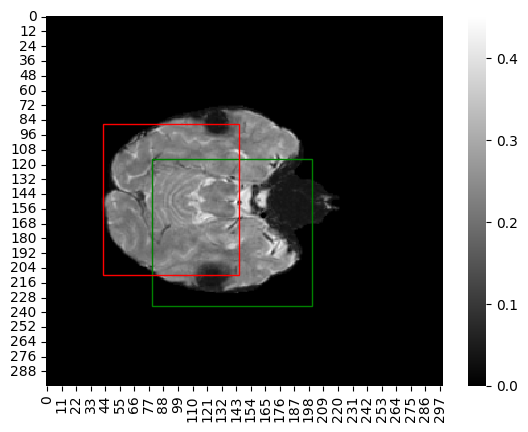

In [48]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = sns.heatmap(rpn_x[rpn_target][0].squeeze().cpu(), cmap='gray')

truth = patches.Rectangle(
    (rpn_bbox[0], rpn_bbox[1]),
    rpn_bbox[2] - rpn_bbox[0],
    rpn_bbox[3] - rpn_bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)

pred = patches.Rectangle(
    (rpn_y[0], rpn_y[1]),
    rpn_y[2] - rpn_y[0],
    rpn_y[3] - rpn_y[1],
    linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(truth)
ax.add_patch(pred)
plt.show()

#### ViT


In [49]:
vit_sample = next(enumerate(vit_test_dataloader))
vit_slices, vit_masks, vit_target, vit_case = vit_sample[1][0]

In [50]:
# vit_slices = vit_slices.squeeze(1).float().to(device)
vit_slices = vit_slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
vit_masks = vit_masks.float().to(device)

In [51]:
vit_x, vit_t = stone(vit_slices, vit_masks, vit_target)

<Axes: title={'center': 'Mask Slice Crop'}>

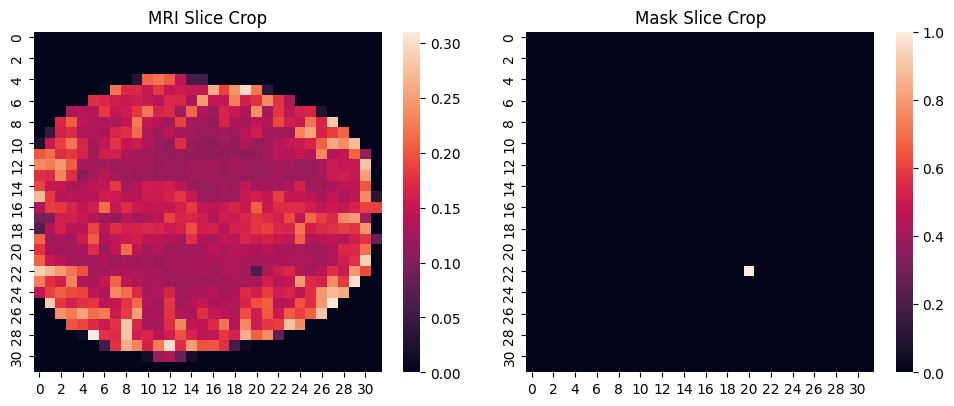

In [52]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('MRI Slice Crop')
ax2.set_title('Mask Slice Crop')
sns.heatmap(vit_x[vit_target].squeeze(), ax=ax1)
sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2)

In [53]:
vit_y = vit_fitter.model(vit_x.flatten(2).to(device), vit_target)
vit_y = vit_y.view(32, 32)

<Axes: title={'center': 'Mask Truth'}>

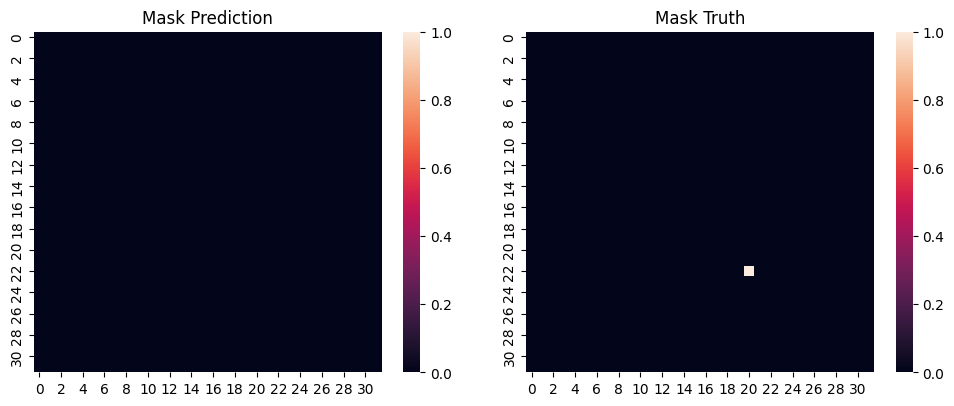

In [54]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')
sns.heatmap((vit_y > -0.3).detach().cpu(), ax=ax1, vmax=1)
sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2, vmax=1)

# Log Progress


In [55]:
vit_tk.notes = '''
Global Context
'''
rpn_tk.notes = '''
Global Context
'''

In [56]:
vit_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-19 22:45:09.944191,ViT,None,None,None,True,True,False,True,<class 'torch.optim.adam.Adam'>,10,...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,None,None,None,"{'d_model': 512, 'patch_size': 32, 'dim_ff': 1...",rpn_vit_Nov_19_2024_224509.log,cuda,\nGlobal Context\n


In [57]:
rpn_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-19 22:45:09.944191,RPN,None,None,True,True,True,False,True,<class 'torch.optim.adam.Adam'>,10,...,0.577839,0.44155,None,None,None,None,"{'input_dim': 512, 'output_dim': 4, 'image_siz...",rpn_vit_Nov_19_2024_224509.log,cuda,\nGlobal Context\n


In [58]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, rpn_tk()])
    merged.to_csv('history/runs.csv')

    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, vit_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    rpn_tk().to_csv('history/runs.csv')

    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, vit_tk()])
    merged.to_csv('history/runs.csv')

Making new csv file


C:\Users\araza\AppData\Local\Temp\ipykernel_11868\1565825461.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([prev_df, vit_tk()])
